<a href="https://colab.research.google.com/github/mipula/Projeto-Integrado-IV/blob/main/PI_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carregar Bibliotecas

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, RocCurveDisplay
%matplotlib inline

In [2]:
!pip install sweetviz
import sweetviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 17.0 MB/s eta 0:00:00


# Carrega Dataset

In [3]:
#Mintel
from google.colab import files
uploaded = files.upload()

Saving Video_Games_Sales_as_at_22_Dec_2016.csv to Video_Games_Sales_as_at_22_Dec_2016.csv


In [4]:
filename = next(iter(uploaded))

In [5]:
data = '/content/'+filename
df = pd.read_csv(data)
pd.options.display.max_columns = None
df.head(5)

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


#Analise Descritiva Inicial

In [6]:
eda=sweetviz.analyze(df)
eda.show_html()

/usr/local/lib/python3.10/dist-packages/sweetviz/dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
/usr/local/lib/python3.10/dist-packages/sweetviz/dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
/usr/local/lib/python3.10/dist-packages/sweetviz/series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
/usr/local/lib/python3.10/dist-packa

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


Conclusão: Vimos a necessidade de tirar o TDB do User_Score, e a necessidade de apagar dados em branco.

# Mapa User_score x Critic_Score

In [7]:
df["User_Score"] = df["User_Score"].replace("tbd", np.nan).astype(float)

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:2214: UserWarning: The marginal plotting function has changed to `histplot`, which does not accept the following argument(s): hist_kws.
  warnings.warn(msg, UserWarning)


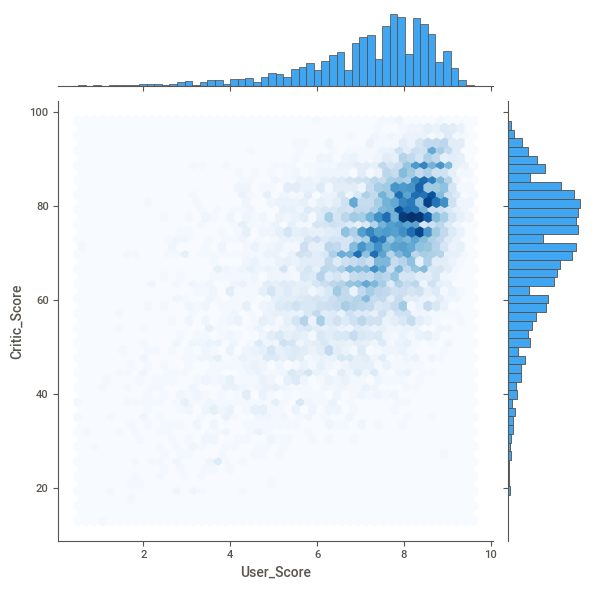

In [8]:
g = sns.jointplot(x=df['User_Score'], y=df['Critic_Score'], data=data, cmap="Blues", kind="hex", 
                  marginal_kws={"hist_kws" : {"edgecolor": "black", "color": "lightskyblue", "alpha": 1}}, 
                 );
g.ax_marg_x.grid(False)
g.ax_marg_y.grid(False);

Com isso vimos uma boa correlação linear entre User_Score e Critic_Score, principalmente para notas mais altas, o que sugere que devamos usar ou outra variável para predições

# Montar Gráfico de Calor Avaliação x Vendas

In [9]:
#Define função que agrupa score
def score_group(score):
    if score >= 90:
        return '90-100'
    elif score >= 80:
        return '80-89'
    elif score >= 70:
        return '70-79'
    elif score >= 60:
        return '60-69'
    elif score >= 50:
        return '50-59'
    else:
        return '0-49'

In [10]:
#Agrupa Score
df['Score_Group1'] = (df['User_Score']*10).apply(lambda x: score_group(x))

<ipython-input-11-d537d5028f4e>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_platform = df[['Genre', 'Score_Group1', 'Global_Sales']].groupby(['Genre', 'Score_Group1']).median().reset_index().pivot('Genre',


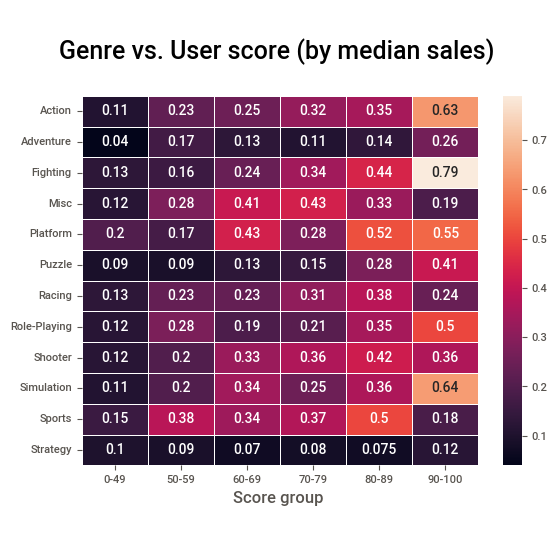

In [11]:
top = df[['Name', 'Genre']].groupby(['Genre']).count().sort_values('Name', ascending=False).reset_index()[:15]
pack = []
for x in top['Genre']:
  pack.append(x)
df_platform = df[['Genre', 'Score_Group1', 'Global_Sales']].groupby(['Genre', 'Score_Group1']).median().reset_index().pivot('Genre', 
                                                                                                          "Score_Group1", "Global_Sales")
sns.heatmap(df_platform, annot=True, fmt=".2g", linewidths=.5).set_title((' \n'+'Genre'+' vs. User score (by median sales) \n'), 
                                                                             fontsize=18)
plt.ylabel('', fontsize=14)
plt.xlabel('Score group \n', fontsize=12)
pack = []

In [12]:
#Agrupa Score
df['Score_Group'] = df['Critic_Score'].apply(lambda x: score_group(x))

<ipython-input-13-ea04a1aaecac>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  df_platform = df[['Genre', 'Score_Group', 'Global_Sales']].groupby(['Genre', 'Score_Group']).median().reset_index().pivot('Genre',


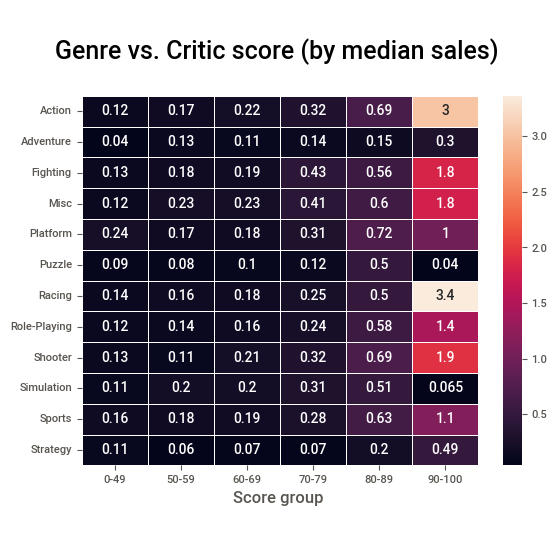

In [13]:
top = df[['Name', 'Genre']].groupby(['Genre']).count().sort_values('Name', ascending=False).reset_index()[:15]
pack = []
for x in top['Genre']:
  pack.append(x)
df_platform = df[['Genre', 'Score_Group', 'Global_Sales']].groupby(['Genre', 'Score_Group']).median().reset_index().pivot('Genre', 
                                                                                                          "Score_Group", "Global_Sales")
sns.heatmap(df_platform, annot=True, fmt=".2g", linewidths=.5).set_title((' \n'+'Genre'+' vs. Critic score (by median sales) \n'), 
                                                                             fontsize=18)
plt.ylabel('', fontsize=14)
plt.xlabel('Score group \n', fontsize=12)
pack = []

A comparação dos mapas de calor da avaliação dos críticos em função da venda global mostrou bem menos correlações do que o mapa de calor com a avaliação dos usuários, o que sugere que seja melhor usar o User_Score, pois contem mais informação.

# DataFrame com User Score

# Aplicação Algorítmos de Agrupamentos (Clusterização)

In [14]:
df_user = df.copy()
col = ['Genre','Global_Sales','Score_Group1']
df_user = df_user[col].dropna()
df_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16717 entries, 0 to 16718
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Genre         16717 non-null  object 
 1   Global_Sales  16717 non-null  float64
 2   Score_Group1  16717 non-null  object 
dtypes: float64(1), object(2)
memory usage: 522.4+ KB


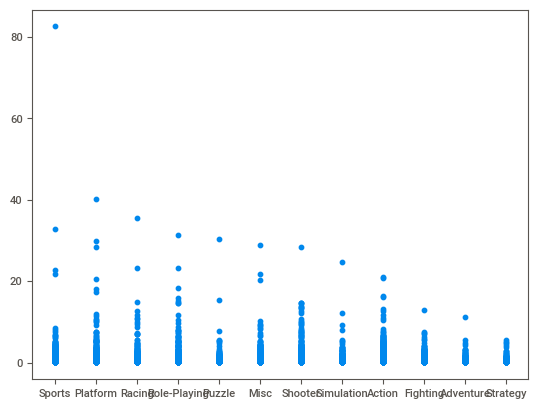

In [15]:
# load the data with pandas
dataset = np.array(df_user)
plt.scatter(dataset[:,0], dataset[:,1], s=10)
plt.show()

## Agrupamento hierárquico

In [16]:
#Transforma o que é Object (string) em Numero
df_user[df_user.select_dtypes(['object']).columns] = df_user[df_user.select_dtypes(['object']).columns].apply(lambda x: pd.factorize(x)[0])

In [17]:
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
plt.rcParams["figure.figsize"] = (15,10)

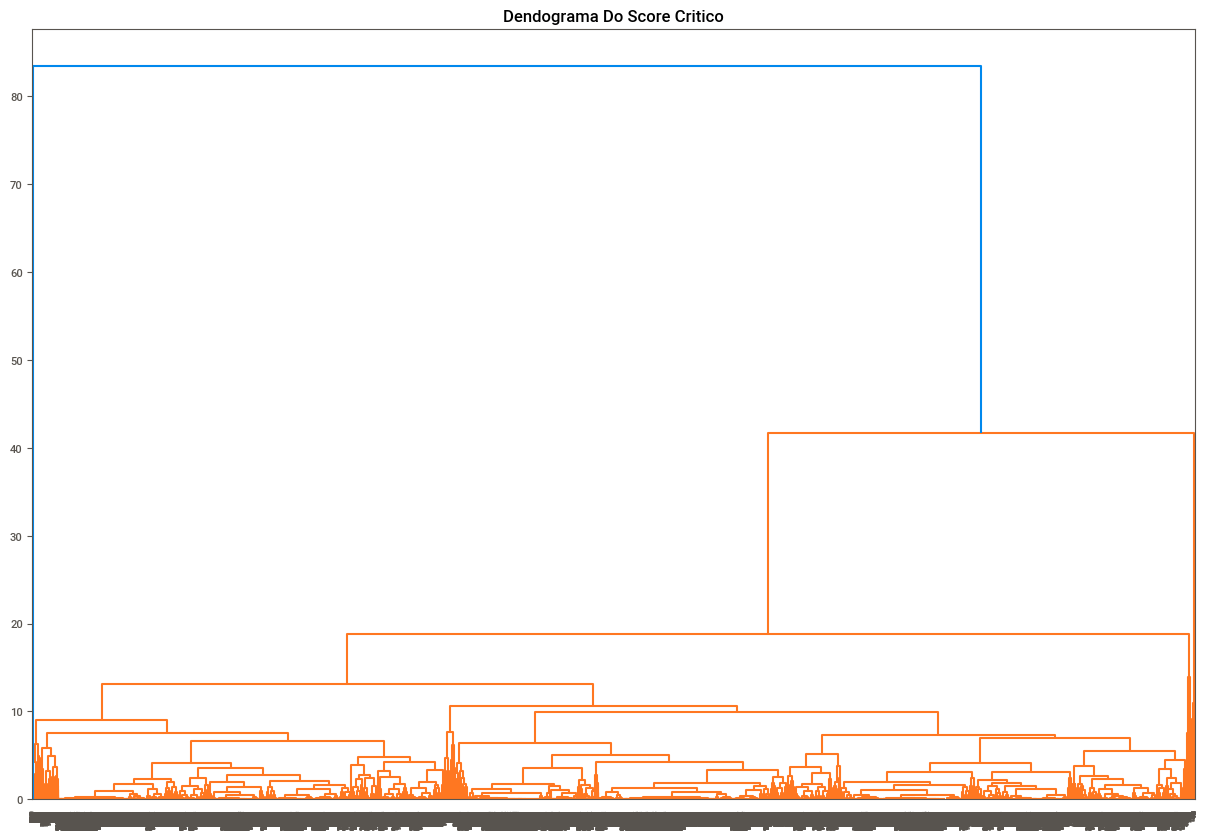

In [18]:
plt.title("Dendograma Do Score Critico")
dendograma = shc.dendrogram(shc.linkage(df_user, method='complete'))

In [19]:
n_grupos = 3
grupos = AgglomerativeClustering(n_clusters=n_grupos, metric='euclidean', linkage='complete')
grupos.fit_predict(df_user)

array([1, 0, 0, ..., 2, 2, 2])

# Separação treino Teste

In [24]:
#Define Variaveis Dependentes
var_dependente=['Genre','Global_Sales']

In [25]:
atributos=df_user[var_dependente]

In [26]:
classe = df_user['Score_Group1']

In [27]:
#Separando os atributos dos rótulos e separando os dados de treinamento (90%) e teste (10%)
atributo_treino, atributo_teste, classes_treino, classes_teste = train_test_split(atributos, classe, test_size = 0.1)

In [28]:
#Diminuindo a escala de dados para melhorar treinamento
scaler = StandardScaler()
atributo_treino = scaler.fit_transform(atributo_treino)
atributo_teste = scaler.transform(atributo_teste)

## Agrupamento usando RandomForest

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
modelo_RF = RandomForestClassifier()
modelo_RF.fit(atributo_treino, classes_treino)

RandomForestClassifier()

In [31]:
predicao_RF = modelo_RF.predict(atributo_teste)
acuracia_RF = accuracy_score(classes_teste, predicao_RF)
print('Acurácia de classificação RF: {}'.format(round(acuracia_RF,3)*100)+'%')

Acurácia de classificação RF: 57.199999999999996%


In [32]:
print(classification_report(classes_teste, predicao_RF))

              precision    recall  f1-score   support

           0       0.33      0.16      0.21       247
           1       0.65      0.89      0.75       995
           2       0.06      0.02      0.03       136
           3       0.21      0.12      0.16       201
           4       0.09      0.06      0.07        18
           5       0.00      0.00      0.00        75

    accuracy                           0.57      1672
   macro avg       0.22      0.21      0.20      1672
weighted avg       0.47      0.57      0.50      1672



# Aplicação Modelos Machine Learning Para USER_SCORE 

## Vizinhos Mais Proximos KNN

In [33]:
from sklearn.neighbors import  KNeighborsClassifier

In [34]:
modelo_kNN = KNeighborsClassifier(n_neighbors = 5)
modelo_kNN.fit(atributo_treino, classes_treino)

KNeighborsClassifier()

In [35]:
#Verificando a Acurácia
predicao_kNN = modelo_kNN.predict(atributo_teste)
acuracia_kNN = accuracy_score(classes_teste, predicao_kNN)
print('Acurácia de classificação k-NN: {}'.format(round(acuracia_kNN, 3)*100)+'%')

Acurácia de classificação k-NN: 53.800000000000004%


In [36]:
print(classification_report(classes_teste, predicao_kNN))

              precision    recall  f1-score   support

           0       0.24      0.23      0.24       247
           1       0.65      0.83      0.73       995
           2       0.04      0.01      0.02       136
           3       0.16      0.08      0.11       201
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        75

    accuracy                           0.54      1672
   macro avg       0.18      0.19      0.18      1672
weighted avg       0.44      0.54      0.48      1672



## Agrupamento usando Maquina de Vetores de Suporte

In [37]:
from sklearn.svm import SVC

In [38]:
#função que recebe os atributos e classes do conjunto de testes, o classificador SVM e plota os resultados
def visualizarSVM(atributos_t,classes_t,classificador):
  atributos, classes = atributos_t, classes_t

  ano, salario = np.meshgrid(np.arange(start = atributos[:, 0].min() - 1, stop = atributos[:, 0].max() + 1, step = 0.01),
                      np.arange(start = atributos[:, 1].min() - 1, stop = atributos[:, 1].max() + 1, step = 0.01))

  plt.contourf(ano, salario, classificador.predict(np.array([ano.ravel(), salario.ravel()]).T).reshape(ano.shape),
              alpha = 0.75, cmap = ListedColormap(('red', 'green')))

  plt.xlim(ano.min(), ano.max())
  plt.ylim(salario.min(), salario.max())

  for i, j in enumerate(np.unique(classes)):
      plt.scatter(atributos[classes == j, 0], atributos[classes == j, 1],
                  color = ListedColormap(('red', 'green'))(i), label = j)

  plt.title('Classificação SVM')
  plt.xlabel('Atibutos')
  plt.ylabel('Classe')
  plt.legend()
  plt.show()

### SVM Linear

In [39]:
modelo_SVM = SVC(kernel = 'linear')
modelo_SVM.fit(atributo_treino, classes_treino)

SVC(kernel='linear')

In [40]:
# Acurácia de classificação com SVM
predicao_SVM = modelo_SVM.predict(atributo_teste)
acuracia_SVM = accuracy_score(classes_teste, predicao_SVM)
print('Acurácia de classificação SVM: {}'.format(round(acuracia_SVM,3)*100)+'%')

Acurácia de classificação SVM: 59.5%


In [41]:
#Precisão, revogação e medida F1
print(classification_report(classes_teste, predicao_SVM))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       247
           1       0.60      1.00      0.75       995
           2       0.00      0.00      0.00       136
           3       0.00      0.00      0.00       201
           4       0.00      0.00      0.00        18
           5       0.00      0.00      0.00        75

    accuracy                           0.60      1672
   macro avg       0.10      0.17      0.12      1672
weighted avg       0.35      0.60      0.44      1672



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


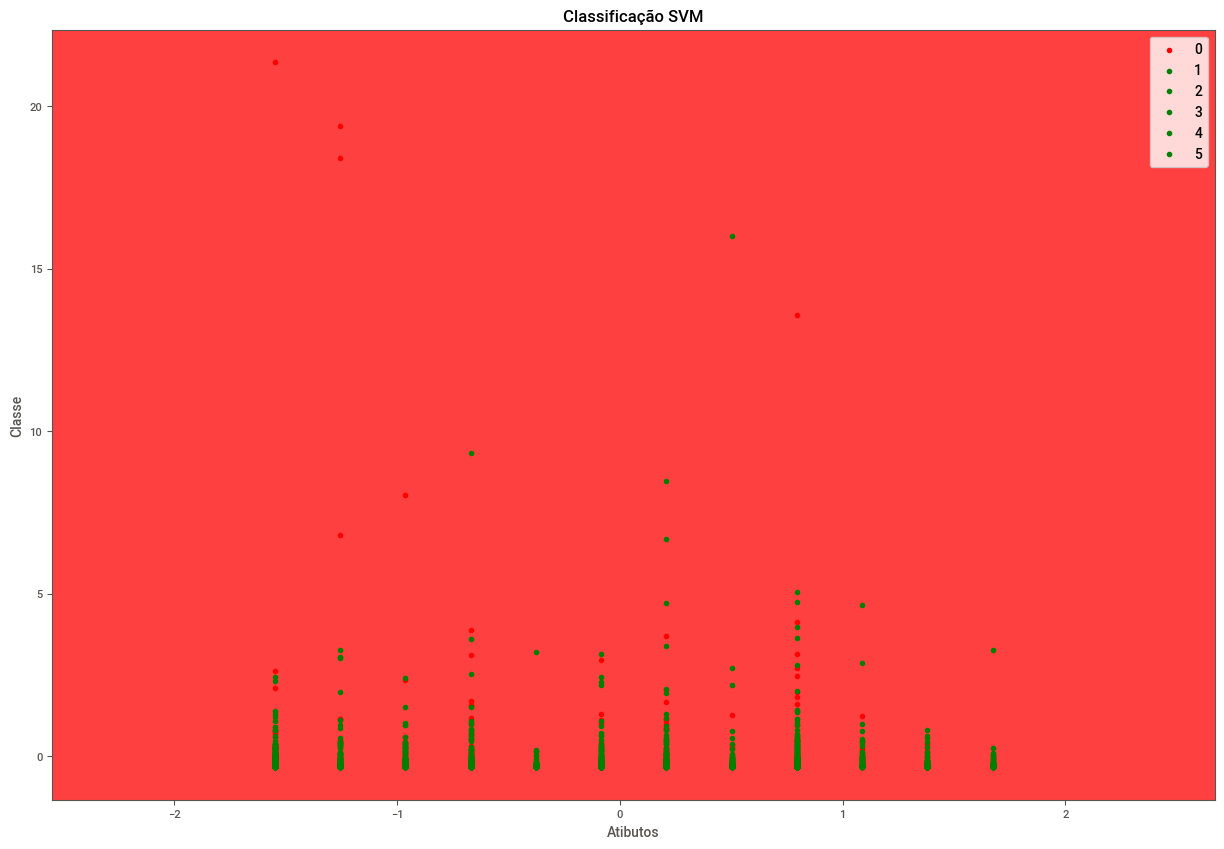

In [42]:
visualizarSVM(atributo_teste, classes_teste,modelo_SVM)

### SVM Sigmoidal

In [43]:
SVM_sigmoidal = SVC(kernel = 'sigmoid', gamma = 'scale', C = 0.2, coef0 = 2)
SVM_sigmoidal.fit(atributo_treino, classes_treino)

SVC(C=0.2, coef0=2, kernel='sigmoid')

In [44]:
predicao_sigmoidal = SVM_sigmoidal.predict(atributo_teste)
acuracia_sigmoidal = accuracy_score(classes_teste,predicao_sigmoidal)
print('Acurácia de classificação: {}'.format(round(acuracia_sigmoidal,3)*100)+'%')

Acurácia de classificação: 55.800000000000004%
